In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
import pickle

# B-spline basis function
def BsFun(i, d, t, Ln):
    if d == 0:
        return 1.0 if Ln[i - 1] <= t < Ln[i] else 0.0
    else:
        a = 0 if (Ln[d + i - 1] - Ln[i - 1]) == 0 else (t - Ln[i - 1]) / (Ln[d + i - 1] - Ln[i - 1])
        b = 0 if (Ln[d + i] - Ln[i]) == 0 else (Ln[d + i] - t) / (Ln[d + i] - Ln[i])
        return a * BsFun(i, d - 1, t, Ln) + b * BsFun(i + 1, d - 1, t, Ln)

# B-spline derivative basis function (first derivative)
def BsFun_derivative(i, d, t, Ln):
    if d == 0:
        return 0.0
    else:
        a = 0 if (Ln[d + i - 1] - Ln[i - 1]) == 0 else d / (Ln[d + i - 1] - Ln[i - 1])
        b = 0 if (Ln[d + i] - Ln[i]) == 0 else d / (Ln[d + i] - Ln[i])
        return a * BsFun(i, d - 1, t, Ln) - b * BsFun(i + 1, d - 1, t, Ln)

# Second derivative of B-spline
def BsFun_second_derivative(i, d, t, Ln):
    if d < 2:
        return 0.0
    else:
        a = 0 if (Ln[d + i - 2] - Ln[i - 2]) == 0 else d * (d - 1) / ((Ln[d + i - 2] - Ln[i - 2]) ** 2)
        b = 0 if (Ln[d + i - 1] - Ln[i - 1]) == 0 else 2 * d * (d - 1) / ((Ln[d + i - 1] - Ln[i - 1]) ** 2)
        c = 0 if (Ln[d + i] - Ln[i]) == 0 else d * (d - 1) / ((Ln[d + i] - Ln[i]) ** 2)
        return a * BsFun(i, d - 2, t, Ln) - b * BsFun(i + 1, d - 2, t, Ln) + c * BsFun(i + 2, d - 2, t, Ln)

# B-spline knots and basis matrix
def BsKnots(n_cp, d, Ns):
    n_knots = n_cp + d + 1
    Ln = np.zeros(n_knots)

    # Construct the knots vector
    for i in range(d + 1, n_knots - d - 1):
        Ln[i] = i - d
    Ln[n_knots - d - 1:] = n_cp - d  # The last d+1 elements should be the same

    # Parameter vector (linearly spaced)
    tk = np.zeros(Ns)
    for i in range(1, Ns):
        tk[i] = tk[i - 1] + Ln[-1] / (Ns - 1)

    # B-spline basis matrix
    Bit = np.zeros((Ns, n_cp))
    for j in range(n_cp):
        for i in range(Ns):
            Bit[i, j] = BsFun(j + 1, d, tk[i], Ln)

    Bit[Ns - 1, n_cp - 1] = 1
    return tk, Ln, Bit

# Compute B-spline basis matrix derivatives
def BsKnots_derivatives(n_cp, d, Ns, Ln, tk):
    # First derivative
    Bit_derivative = np.zeros((Ns, n_cp))
    for j in range(n_cp):
        for i in range(Ns):
            Bit_derivative[i, j] = BsFun_derivative(j + 1, d, tk[i], Ln)

    # Second derivative
    Bit_second_derivative = np.zeros((Ns, n_cp))
    for j in range(n_cp):
        for i in range(Ns):
            Bit_second_derivative[i, j] = BsFun_second_derivative(j + 1, d, tk[i], Ln)

    return Bit_derivative, Bit_second_derivative

# Compute derivatives of B-spline surfaces
def compute_bspline_derivatives(U_full, Bit_t, Bit_x, Bit_t_derivative, Bit_x_derivative):
    # First derivative with respect to time t (using first derivative of Bit_t)
    B_surface_t = torch.matmul(torch.matmul(Bit_t_derivative, U_full), Bit_x.T)

    # First derivative with respect to space x (using first derivative of Bit_x)
    B_surface_x = torch.matmul(torch.matmul(Bit_t, U_full), Bit_x_derivative.T)

    return B_surface_t, B_surface_x

Training Data - beta and phase change

In [ ]:
import numpy as np
import torch
import pickle
from tqdm import tqdm

# Constants for data generation
beta_range = (0.5, 1.5)  # Range of advection speeds
L_x = 1.0                # Length of the spatial domain
nx = 100                 # Number of spatial points
x = np.linspace(0, L_x, nx)  # Spatial grid

t_ini, t_fin = 0.0, 2.0  # Temporal domain
nt = 100                 # Number of temporal points
t = np.linspace(t_ini, t_fin, nt)  # Temporal grid

# We fix wave_number = 2*pi (one single wave),
# amplitude = 1, and random phase phi in [0, 2*pi).
# Then u0(x) = sin(2*pi*x + phi).

def initial_condition_sin_phase(x, phi):
    """
    Single-wave initial condition with random phase:
      u0(x) = sin(2*pi*x + phi)
    """
    return np.sin(2.0 * np.pi * x + phi)

def exact_solution_advection_phase(x, t, beta, phi):
    """
    Exact solution for pure advection with speed beta and random phase phi:
      u(t, x) = sin( 2*pi*( (x - beta*t) mod L_x ) + phi )
    """
    # Shift x by beta*t, apply modulo L_x
    x_shifted = (x - beta * t) % L_x
    return np.sin(2.0 * np.pi * x_shifted + phi)

# Generate training data
num_samples = 100  # Number of training samples
training_data = []

for _ in tqdm(range(num_samples), desc="Generating Training Data"):
    # Random beta in [0.8, 1.2]
    beta = np.random.uniform(*beta_range)

    # Random phase in [0, 2*pi)
    phi = np.random.uniform(0, 2.0 * np.pi)

    # wave_number = 2*pi, amplitude = 1
    wave_numbers_np = np.array([2.0 * np.pi], dtype=np.float32)
    amplitudes_np = np.array([1.0], dtype=np.float32)
    phases_np = np.array([phi], dtype=np.float32)

    # Build initial condition u0(x)
    u0 = initial_condition_sin_phase(x, phi)

    # Calculate the exact solution for all time steps
    U = np.zeros((nt, nx), dtype=np.float32)
    for j, tj in enumerate(t):
        U[j, :] = exact_solution_advection_phase(x, tj, beta, phi)

    # Store the data
    training_data.append({
        'beta': torch.tensor([[beta]], dtype=torch.float32),      # shape (1,1)
        'wave_numbers': torch.tensor(wave_numbers_np),            # shape (1,)
        'amplitudes': torch.tensor(amplitudes_np),                # shape (1,)
        'phases': torch.tensor(phases_np),                        # shape (1,)
        'x': torch.tensor(x, dtype=torch.float32),                # shape (nx,)
        't': torch.tensor(t, dtype=torch.float32),                # shape (nt,)
        'U': torch.tensor(U, dtype=torch.float32)                 # shape (nt, nx)
    })

# Save the training data
with open('advection_training_data.pkl', 'wb') as f:
    pickle.dump(training_data, f)

print("Data generation complete.")


Generating Training Data: 100%|██████████| 100/100 [00:00<00:00, 488.94it/s]


Data generation complete.


Testing Data

In [ ]:
import numpy as np
import torch
import pickle
from tqdm import tqdm

# Constants for data generation
beta_range = (0.5, 1.5)  # Range of advection speeds
L_x = 1.0                # Length of the spatial domain
nx = 100                 # Number of spatial points
x = np.linspace(0, L_x, nx)  # Spatial grid

t_ini, t_fin = 0.0, 2.0  # Temporal domain
nt = 100                 # Number of temporal points
t = np.linspace(t_ini, t_fin, nt)  # Temporal grid

# Single sine wave with random phase:
#   u0(x) = sin(2*pi*x + phi).
def initial_condition_sin_phase(x, phi):
    return np.sin(2.0 * np.pi * x + phi)

# Exact advection solution:
#   u(t,x) = sin(2*pi * ((x - beta*t) mod L_x) + phi)
def exact_solution_advection_phase(x, t, beta, phi):
    x_shifted = (x - beta * t) % L_x
    return np.sin(2.0 * np.pi * x_shifted + phi)

# Generate testing data
num_test_samples = 30  # Number of testing samples
testing_data = []

for _ in tqdm(range(num_test_samples), desc="Generating Testing Data"):
    # 1) Random advection speed in [0.8, 1.2]
    beta = np.random.uniform(*beta_range)
    # 2) Random phase in [0, 2*pi)
    phi = np.random.uniform(0, 2.0 * np.pi)

    # We fix wave_number=2*pi, amplitude=1
    wave_numbers_np = np.array([2.0 * np.pi], dtype=np.float32)
    amplitudes_np   = np.array([1.0],         dtype=np.float32)
    phases_np       = np.array([phi],         dtype=np.float32)

    # Build initial condition at x
    u0 = initial_condition_sin_phase(x, phi)  # shape (nx,)

    # Calculate the exact solution for all time steps
    U = np.zeros((nt, nx), dtype=np.float32)
    for j, tj in enumerate(t):
        U[j, :] = exact_solution_advection_phase(x, tj, beta, phi)

    # Store in the same structure used for training
    testing_data.append({
        'beta': torch.tensor([[beta]], dtype=torch.float32),    # shape (1,1)
        'wave_numbers': torch.tensor(wave_numbers_np),          # shape (1,)
        'amplitudes': torch.tensor(amplitudes_np),              # shape (1,)
        'phases': torch.tensor(phases_np),                      # shape (1,)
        'x': torch.tensor(x, dtype=torch.float32),              # shape (nx,)
        't': torch.tensor(t, dtype=torch.float32),              # shape (nt,)
        'U': torch.tensor(U, dtype=torch.float32)               # shape (nt, nx)
    })

# Save the testing data to a separate file
with open('advection_testing_data.pkl', 'wb') as f:
    pickle.dump(testing_data, f)

print("Testing data generation complete.")


Generating Testing Data: 100%|██████████| 30/30 [00:00<00:00, 1012.29it/s]


Testing data generation complete.


Data Visualization

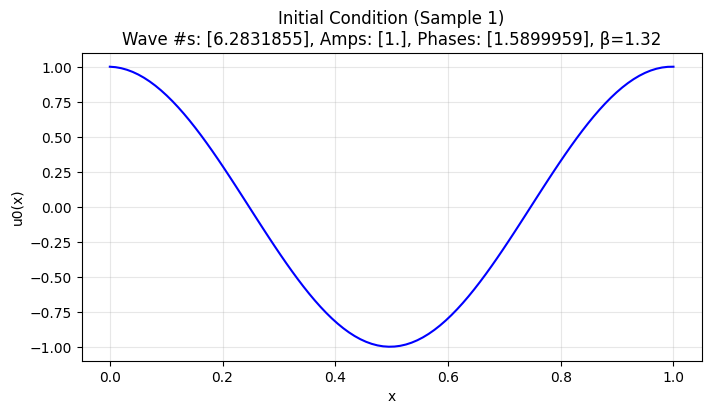

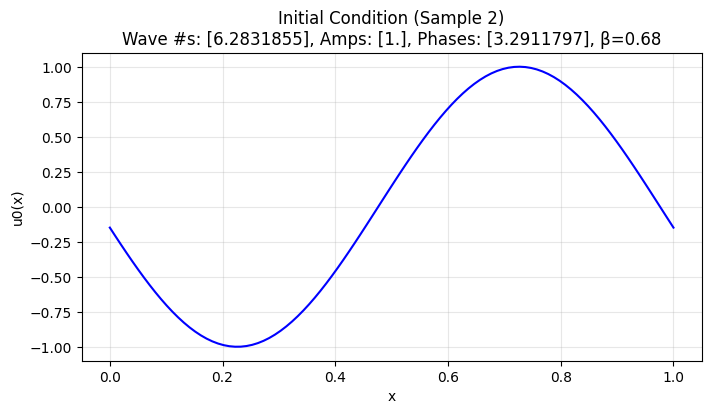

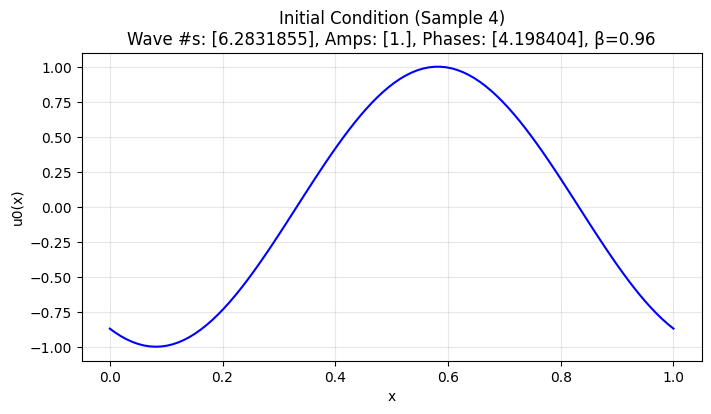

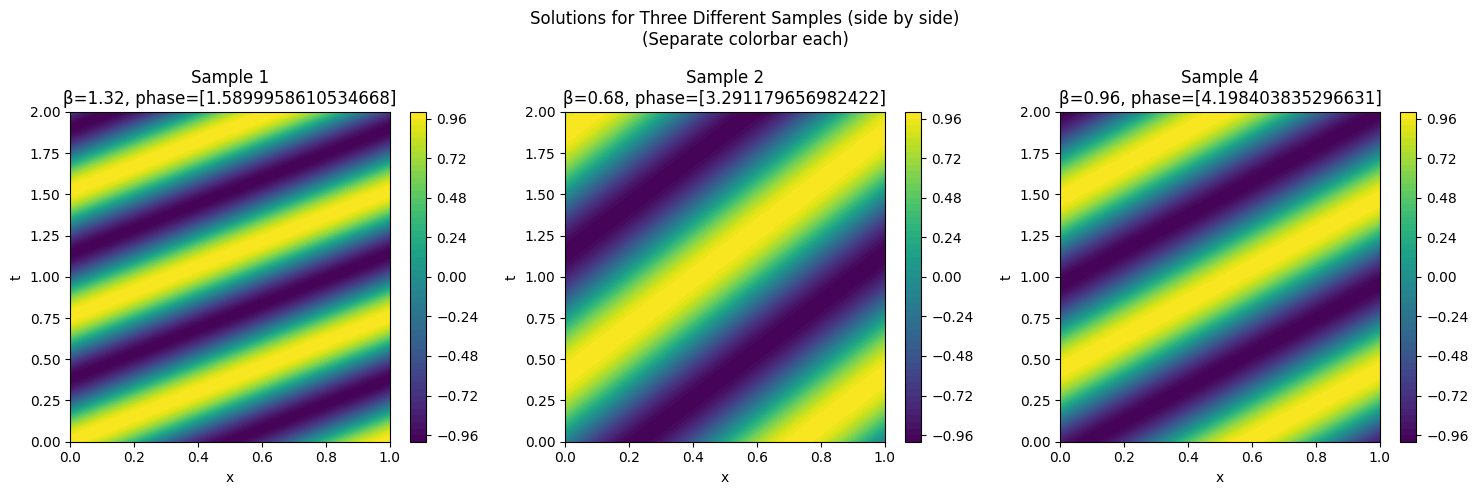

In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

# 1. Load the training data
with open('advection_training_data.pkl', 'rb') as f:
    training_data = pickle.load(f)

# Choose three different samples to visualize
sample_indices = [1, 2, 4]  # Adjust to whichever samples you like

###############################################################
# A) Plot each sample's initial condition in separate figures
###############################################################
for idx in sample_indices:
    sample = training_data[idx]

    # Extract data
    x = sample['x'].numpy()                # Spatial grid (Nx,)
    U = sample['U'].numpy()                # (Nt, Nx)
    u0 = U[0, :]                            # Initial condition (Nx,)
    wave_numbers = sample['wave_numbers'].numpy()
    amplitudes  = sample['amplitudes'].numpy()
    phases      = sample['phases'].numpy()
    beta        = sample['beta'].item()

    # Plot the initial condition
    plt.figure(figsize=(8, 4))
    plt.plot(x, u0, color='blue')
    plt.title(f"Initial Condition (Sample {idx})\n"
              f"Wave #s: {wave_numbers}, Amps: {amplitudes}, Phases: {phases}, β={beta:.2f}")
    plt.xlabel("x")
    plt.ylabel("u0(x)")
    plt.grid(alpha=0.3)
    plt.show()

#######################################################################
# B) Show the solutions of all three samples side by side in one figure
#    Each subplot has its own colorbar, plus β and phase info in the title
#######################################################################
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, idx in enumerate(sample_indices):
    sample = training_data[idx]
    x = sample['x'].numpy()
    t = sample['t'].numpy()
    U = sample['U'].numpy()    # shape (Nt, Nx)

    # PDE parameters
    beta   = sample['beta'].item()
    phases = sample['phases'].numpy().tolist()

    # Create mesh for contour
    X, T = np.meshgrid(x, t)

    cs = axes[i].contourf(X, T, U, levels=50, cmap='viridis')
    # Separate colorbar for each subplot
    cbar = fig.colorbar(cs, ax=axes[i])

    # If your data contains multiple wave phases, we show them as a list
    axes[i].set_title(f"Sample {idx}\nβ={beta:.2f}, phase={phases}")
    axes[i].set_xlabel("x")
    axes[i].set_ylabel("t")

plt.suptitle("Solutions for Three Different Samples (side by side)\n(Separate colorbar each)")

plt.tight_layout()
plt.show()


LS Test

A shape: (100, 200), B shape: (100, 200), F shape: (100, 100)
Q_hat shape: (200, 200)
F_reconstructed shape: (100, 100)
Mean Reconstruction Error: 0.000002


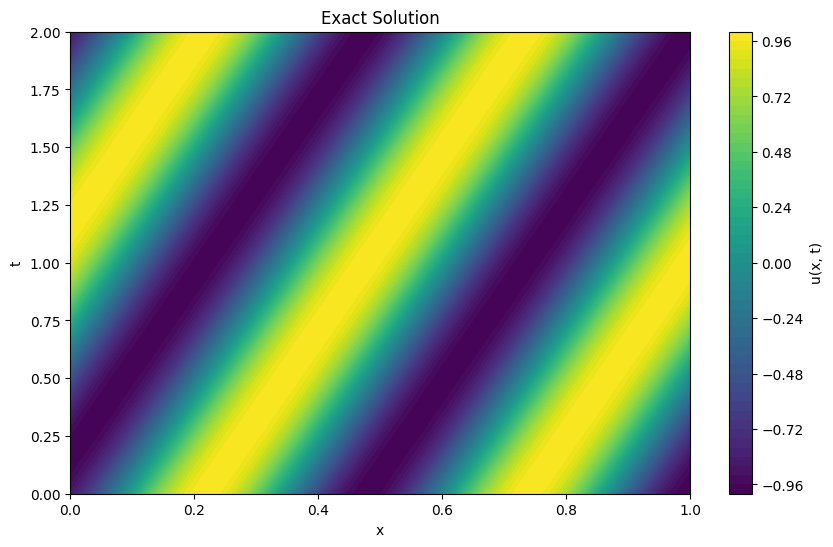

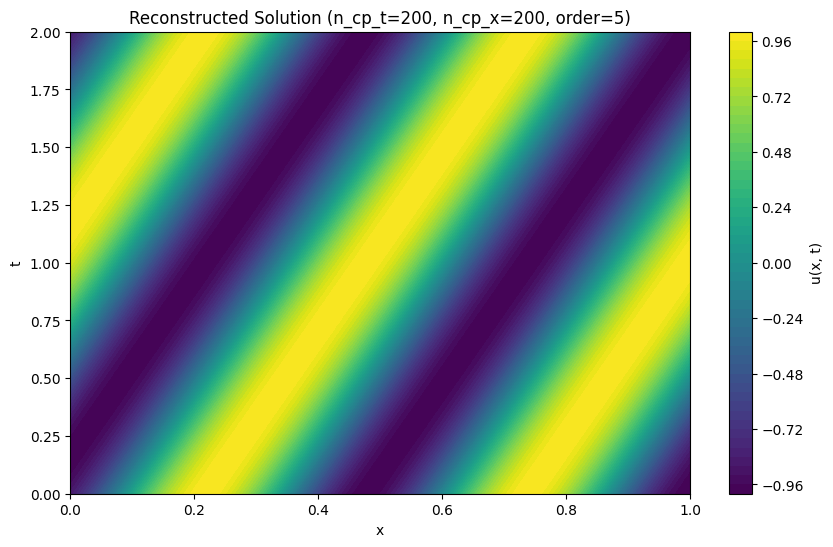

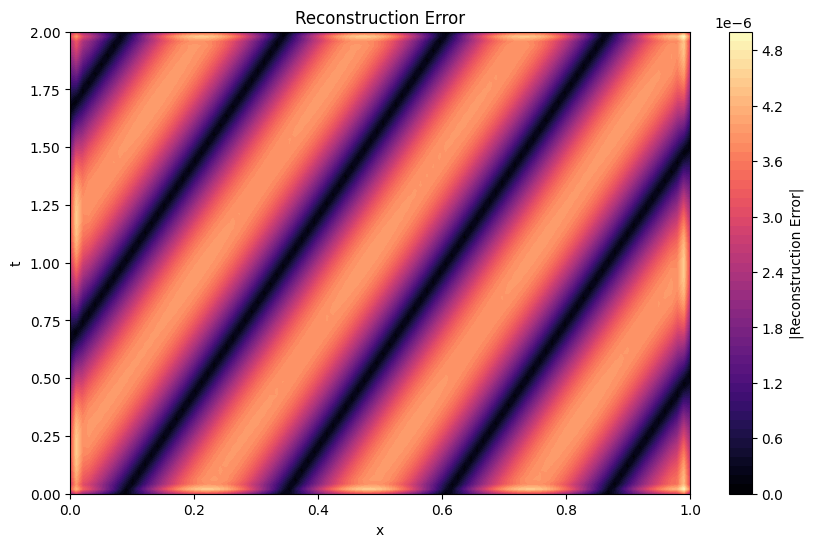

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_control_points(A, B, F, reg=1e-6):
    """
    Solve the 2D least squares problem F ~ A Q B^T with Tikhonov regularization.
    A: (n_t, n_cp_t)    B: (n_x, n_cp_x)     F: (n_t, n_x)
    Q: (n_cp_t, n_cp_x)

    Returns:
    Q_hat of shape (n_cp_t, n_cp_x)
    """
    # Check matrix dimensions
    n_t, n_cp_t = A.shape
    n_x, n_cp_x = B.shape
    if F.shape != (n_t, n_x):
        raise ValueError(f"F must be of shape {(n_t, n_x)}, got {F.shape}.")

    # regularization matrices
    I_t = reg * np.eye(n_cp_t)    # shape (n_cp_t, n_cp_t)
    I_x = reg * np.eye(n_cp_x)    # shape (n_cp_x, n_cp_x)

    # 1. (A^T A + lambda I)^{-1} (A^T F)
    lhs_time = np.linalg.solve(A.T @ A + I_t, A.T @ F)  # shape (n_cp_t, n_x)

    # 2. (B^T B + lambda I)^{-1} B^T
    lhs_space = np.linalg.solve(B.T @ B + I_x, B.T)     # shape (n_cp_x, n_x)

    # 3. Q_hat = lhs_time @ lhs_space^T
    #    lhs_time:   (n_cp_t, n_x)
    #    lhs_space^T (n_x, n_cp_x)
    Q_hat = lhs_time @ lhs_space.T  # shape (n_cp_t, n_cp_x)
    return Q_hat

# ------------------------ MAIN SCRIPT -------------------------------- #

# Load the testing sample
sample_index = 4
sample = training_data[sample_index]

F_true_test = sample['U'].numpy().T  # shape (Nt, Nx)
x = sample['x'].numpy()  # shape (Nx,)
t = sample['t'].numpy()  # shape (Nt,)
X, T = np.meshgrid(x, t)

# Configuration: number of control points / order
n_cp_t = 200
n_cp_x = 200
d = 5

n_t, n_x = F_true_test.shape

# Generate B-spline basis matrices using your functions
tk_t, Ln_t, Bit_t = BsKnots(n_cp_t, d, n_t)  # shape (n_t, n_cp_t)
tk_x, Ln_x, Bit_x = BsKnots(n_cp_x, d, n_x)  # shape (n_x, n_cp_x)

# Convert to numpy arrays if needed
A = np.array(Bit_t)  # (n_t, n_cp_t)
B = np.array(Bit_x)  # (n_x, n_cp_x)
F = F_true_test      # (n_t, n_x)

print(f"A shape: {A.shape}, B shape: {B.shape}, F shape: {F.shape}")

# Solve for Q_hat
Q_hat = calculate_control_points(A, B, F, reg=1e-6)
print("Q_hat shape:", Q_hat.shape)

# Reconstruct the solution: F_reconstructed = A Q_hat B^T
F_reconstructed = A @ Q_hat @ B.T
print("F_reconstructed shape:", F_reconstructed.shape)

# Compute error
reconstruction_error = np.abs(F_reconstructed - F)
mean_error = reconstruction_error.mean()
print(f"Mean Reconstruction Error: {mean_error:.6f}")

# Visualization
plt.figure(figsize=(10, 6))
plt.contourf(X, T, F, levels=50, cmap='viridis')
plt.colorbar(label='u(x, t)')
plt.title("Exact Solution")
plt.xlabel("x")
plt.ylabel("t")
plt.show()

plt.figure(figsize=(10, 6))
plt.contourf(X, T, F_reconstructed, levels=50, cmap='viridis',
             vmin=F.min(), vmax=F.max())
plt.colorbar(label='u(x, t)')
plt.title(f"Reconstructed Solution (n_cp_t={n_cp_t}, n_cp_x={n_cp_x}, order={d})")
plt.xlabel("x")
plt.ylabel("t")
plt.show()

plt.figure(figsize=(10, 6))
plt.contourf(X, T, reconstruction_error, levels=50, cmap='magma')
plt.colorbar(label='|Reconstruction Error|')
plt.title("Reconstruction Error")
plt.xlabel("x")
plt.ylabel("t")
plt.show()


BS Net Training

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
from tqdm import tqdm


###############################################################################
# Neural Network that predicts B-spline control points from (beta, phase)
###############################################################################
class BetaPhaseControlPointNet(nn.Module):
    def __init__(self, n_cp_x, n_cp_t, hidden_dim=64):
        super(BetaPhaseControlPointNet, self).__init__()
        # Input dimension: 2 => [beta, phase]
        self.fc1 = nn.Linear(2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, n_cp_x * n_cp_t)

        self.n_cp_t = n_cp_t
        self.n_cp_x = n_cp_x

    def forward(self, beta, phase):
        """
        beta:  shape (batch_size, 1)
        phase: shape (batch_size, 1)
        We concat => shape (batch_size, 2)
        return shape => (n_cp_t, n_cp_x) if batch_size=1
        """
        x = torch.cat((beta, phase), dim=1)  # shape => (batch_size, 2)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        out = self.fc3(x)  # shape => (batch_size, n_cp_t * n_cp_x)
        # If batch=1, reshape => (n_cp_t, n_cp_x)
        return out.view(-1, self.n_cp_t, self.n_cp_x)


###############################################################################
# Compute partial derivatives of the B-spline surface
###############################################################################
def compute_bspline_derivatives(U_full, Bit_t, Bit_x, Bit_t_derivative, Bit_x_derivative):
    """
    Approx. partial derivatives of the B-spline surface:
      B_surface_t ~ d/dt (B_surface)
      B_surface_x ~ d/dx (B_surface)
    """
    B_surface_t = torch.matmul(torch.matmul(Bit_t_derivative, U_full), Bit_x.T)
    B_surface_x = torch.matmul(torch.matmul(Bit_t, U_full), Bit_x_derivative.T)
    return B_surface_t, B_surface_x


###############################################################################
# Helper: Overwrite first row of U_pred with the initial condition (canvas approach)
###############################################################################
def assign_first_row_direct(U_pred, u0_values):
    """
    Overwrite row 0 in U_pred with the actual initial condition.
    If n_cp_x != len(u0_values), we interpolate.

    U_pred: shape (n_cp_t, n_cp_x) or (1, n_cp_t, n_cp_x)
    u0_values: shape (Nx,)
    """
    # If there's a batch dimension, handle that
    if U_pred.ndim == 3:
        # U_pred[0] => shape (n_cp_t, n_cp_x)
        row0 = U_pred[0, 0, :]
        n_cp_x = U_pred.shape[2]
    else:
        row0 = U_pred[0, :]
        n_cp_x = U_pred.shape[1]

    Nx = len(u0_values)
    if n_cp_x == Nx:
        row0[:] = torch.from_numpy(u0_values)
    else:
        x_data = np.arange(Nx)
        x_cp = np.linspace(0, Nx - 1, n_cp_x)
        row0_cp = np.interp(x_cp, x_data, u0_values)  # shape: (n_cp_x,)
        row0[:] = torch.from_numpy(row0_cp)


###############################################################################
# Main Training Code
###############################################################################
# 1. Load training data
with open('advection_training_data.pkl', 'rb') as f:
    training_data = pickle.load(f)

# 2. Define hyperparameters
n_cp_t = 150
n_cp_x = 150
d = 5  # B-spline order
hidden_dim = 64
epochs = 2000
lr = 0.001

# Suppose your B-spline basis functions are defined as:
#   BsKnots(n_cp, d, N) -> (tk, Ln, Bit)
#   BsKnots_derivatives(n_cp, d, N, Ln, tk) -> (Bit_derivative, Bit_second_derivative)
# We'll assume they've been implemented.

# 3. Build B-spline basis
tk_x, Ln_x, Bit_x = BsKnots(n_cp_x, d, len(training_data[0]['x']))
Bit_x_derivative, _ = BsKnots_derivatives(n_cp_x, d, len(training_data[0]['x']), Ln_x, tk_x)
tk_t, Ln_t, Bit_t = BsKnots(n_cp_t, d, len(training_data[0]['t']))
Bit_t_derivative, _ = BsKnots_derivatives(n_cp_t, d, len(training_data[0]['t']), Ln_t, tk_t)

# Convert them to PyTorch tensors
Bit_x = torch.tensor(Bit_x, dtype=torch.float32)
Bit_t = torch.tensor(Bit_t, dtype=torch.float32)
Bit_x_derivative = torch.tensor(Bit_x_derivative, dtype=torch.float32)
Bit_t_derivative = torch.tensor(Bit_t_derivative, dtype=torch.float32)

# 4. Initialize the model & optimizer
# Now we use BetaPhaseControlPointNet
model = BetaPhaseControlPointNet(n_cp_x, n_cp_t, hidden_dim)
optimizer = optim.Adam(model.parameters(), lr=lr)

# We'll do MSE for PDE + data losses
mse_loss = nn.MSELoss(reduction='mean')

# 5. Training Loop
for epoch in tqdm(range(epochs), desc="Training Epochs"):
    total_loss = 0.0

    for sample in training_data:
        optimizer.zero_grad()

        # Extract PDE param (beta) => shape(1,1)
        beta = sample['beta']
        # Extract phase => shape(1,)
        phases = sample['phases']  # shape(1,) if we used one wave
        # Convert phase => shape(1,1)
        phases = phases.view(1, -1)  # so we can do cat((beta, phases), dim=1)

        # The ground truth solution => shape (Nt, Nx)
        U_tensor = sample['U']

        # The initial condition => shape (Nx,)
        u0_numpy = U_tensor[0, :].numpy()

        # Predict B-spline control points from (beta, phases)
        U_pred = model(beta, phases)  # shape => (1, n_cp_t, n_cp_x) if batch=1

        # Overwrite row 0 with actual initial condition
        assign_first_row_direct(U_pred, u0_numpy)

        # Reshape if needed => (n_cp_t, n_cp_x)
        if U_pred.ndim == 3:
            U_pred = U_pred[0]

        # B-spline reconstruction => shape (Nt, Nx)
        B_surface = torch.matmul(torch.matmul(Bit_t, U_pred), Bit_x.T)

        # PDE derivatives: ∂_t + beta ∂_x = 0
        B_surface_t, B_surface_x = compute_bspline_derivatives(
            U_pred, Bit_t, Bit_x, Bit_t_derivative, Bit_x_derivative
        )
        pde_residual = B_surface_t + beta * B_surface_x

        # Loss => PDE + data
        physics_loss = mse_loss(pde_residual, torch.zeros_like(pde_residual))
        data_loss    = mse_loss(B_surface, U_tensor)
        loss = 1 * physics_loss + 10 * data_loss

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if epoch % 100 == 0:
        avg_loss = total_loss / len(training_data)
        print(f"Epoch {epoch}, Average Loss: {avg_loss:.4f}")

print("Training complete.")


Training Epochs:   0%|          | 1/2000 [00:00<26:37,  1.25it/s]

Epoch 0, Average Loss: 5.0205


Training Epochs:   5%|▌         | 101/2000 [01:36<30:06,  1.05it/s]

Epoch 100, Average Loss: 0.5800


Training Epochs:  10%|█         | 201/2000 [03:13<28:28,  1.05it/s]

Epoch 200, Average Loss: 0.2246


Training Epochs:  15%|█▌        | 301/2000 [04:50<26:47,  1.06it/s]

Epoch 300, Average Loss: 0.1573


Training Epochs:  20%|██        | 401/2000 [06:27<25:36,  1.04it/s]

Epoch 400, Average Loss: 0.0932


Training Epochs:  25%|██▌       | 501/2000 [08:05<25:30,  1.02s/it]

Epoch 500, Average Loss: 0.0811


Training Epochs:  30%|███       | 601/2000 [09:51<24:57,  1.07s/it]

Epoch 600, Average Loss: 0.0608


Training Epochs:  35%|███▌      | 701/2000 [12:00<30:20,  1.40s/it]

Epoch 700, Average Loss: 0.0409


Training Epochs:  40%|████      | 801/2000 [14:20<28:47,  1.44s/it]

Epoch 800, Average Loss: 0.0349


Training Epochs:  45%|████▌     | 901/2000 [16:40<25:27,  1.39s/it]

Epoch 900, Average Loss: 0.0424


Training Epochs:  50%|█████     | 1001/2000 [19:00<23:30,  1.41s/it]

Epoch 1000, Average Loss: 0.0307


Training Epochs:  55%|█████▌    | 1101/2000 [21:19<20:31,  1.37s/it]

Epoch 1100, Average Loss: 0.0405


Training Epochs:  60%|██████    | 1201/2000 [23:38<18:26,  1.39s/it]

Epoch 1200, Average Loss: 0.0496


Training Epochs:  65%|██████▌   | 1301/2000 [25:58<16:44,  1.44s/it]

Epoch 1300, Average Loss: 0.0408


Training Epochs:  70%|███████   | 1401/2000 [28:17<13:44,  1.38s/it]

Epoch 1400, Average Loss: 0.0231


Training Epochs:  75%|███████▌  | 1501/2000 [30:37<11:39,  1.40s/it]

Epoch 1500, Average Loss: 0.0191


Training Epochs:  80%|████████  | 1601/2000 [32:56<09:05,  1.37s/it]

Epoch 1600, Average Loss: 0.0198


Training Epochs:  85%|████████▌ | 1701/2000 [35:16<06:54,  1.39s/it]

Epoch 1700, Average Loss: 0.0422


Training Epochs:  90%|█████████ | 1801/2000 [37:35<04:46,  1.44s/it]

Epoch 1800, Average Loss: 0.0274


Training Epochs:  95%|█████████▌| 1901/2000 [39:55<02:17,  1.39s/it]

Epoch 1900, Average Loss: 0.0238


Training Epochs: 100%|██████████| 2000/2000 [42:14<00:00,  1.27s/it]

Training complete.


Testing

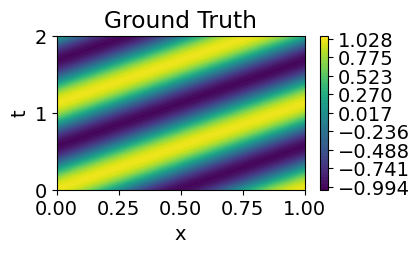

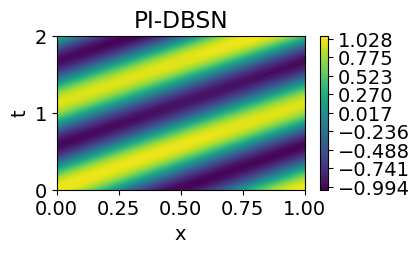

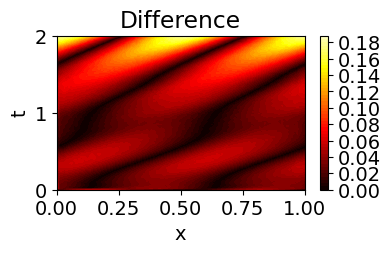

Sample 18, Mean Absolute Error: 0.0436


In [ ]:
import matplotlib.pyplot as plt
import torch
import pickle
import numpy as np

###############################################################################
# Overwrite row 0 in U_pred with the actual initial condition (if needed)
###############################################################################
def assign_first_row_direct(U_pred, u0_values):
    """
    Overwrite row 0 in U_pred with the actual initial condition.
    If n_cp_x != len(u0_values), we interpolate.

    U_pred: shape (n_cp_t, n_cp_x) or (1, n_cp_t, n_cp_x)
    u0_values: shape (Nx,)
    """
    if U_pred.ndim == 3:
        row0 = U_pred[0, 0, :]
        n_cp_x = U_pred.shape[2]
    else:
        row0 = U_pred[0, :]
        n_cp_x = U_pred.shape[1]

    Nx = len(u0_values)
    if n_cp_x == Nx:
        row0[:] = torch.from_numpy(u0_values)
    else:
        x_data = np.arange(Nx)
        x_cp = np.linspace(0, Nx - 1, n_cp_x)
        row0_cp = np.interp(x_cp, x_data, u0_values)  # shape: (n_cp_x,)
        row0[:] = torch.from_numpy(row0_cp)

########################
# 1. Load model and data
########################
# model = torch.load("my_trained_model.pt")
# model.eval()

with open('advection_testing_data.pkl', 'rb') as f:
    testing_data = pickle.load(f)

# Suppose Bit_t, Bit_x are torch.Tensor in scope
# e.g., Bit_t, Bit_x = ...

########################################
# 2. Pick a sample to test
########################################
sample_index = 18
sample = testing_data[sample_index]

# Extract data
beta  = sample['beta']    # shape (1,1)
phase = sample['phases']  # shape (1,) if single wave
U_exact = sample['U'].numpy()   # (Nt, Nx)
x = sample['x'].numpy()         # (Nx,)
t = sample['t'].numpy()         # (Nt,)

X, T = np.meshgrid(x, t)        # For contour plots

########################################
# 3. Model Prediction
########################################
phase = phase.view(1, -1)  # shape => (1,1)
with torch.no_grad():
    U_pred = model(beta, phase)  # shape => (n_cp_t, n_cp_x) or (1, n_cp_t, n_cp_x)
    if U_pred.ndim == 3:
        U_pred = U_pred[0]

# Overwrite first row if needed
u0_numpy = U_exact[0, :]
assign_first_row_direct(U_pred, u0_numpy)

# B-spline reconstruction => shape (Nt, Nx)
B_surface_pred = torch.matmul(torch.matmul(Bit_t, U_pred), Bit_x.T)
B_surface_pred = B_surface_pred.squeeze().numpy()  # ensure 2D

difference = np.abs(B_surface_pred - U_exact)

########################
# 4. Visualization
########################
plt.rcParams.update({'font.size': 14})

# (a) Determine common color range
vmin = min(U_exact.min(), B_surface_pred.min())
vmax = max(U_exact.max(), B_surface_pred.max())

# Create consistent levels for both GT and Pred
levels = np.linspace(vmin, vmax, 51)  # 51 levels => 50 color bands

########################################
# Plot 1: Ground Truth
########################################
fig1, ax1 = plt.subplots(figsize=(4, 2))
contour0 = ax1.contourf(X, T, U_exact, levels=levels, cmap='viridis',
                        vmin=vmin, vmax=vmax)
cbar1 = plt.colorbar(contour0, ax=ax1)
ax1.set_title('Ground Truth')
ax1.set_xlabel('x')
ax1.set_ylabel('t')
fig1.savefig(f'GT_sample{sample_index}.pdf', bbox_inches='tight')

########################################
# Plot 2: Predicted
########################################
fig2, ax2 = plt.subplots(figsize=(4, 2))
contour1 = ax2.contourf(X, T, B_surface_pred, levels=levels, cmap='viridis',
                        vmin=vmin, vmax=vmax)
cbar2 = plt.colorbar(contour1, ax=ax2)
ax2.set_title('PI-BSNet')
ax2.set_xlabel('x')
ax2.set_ylabel('t')
fig2.savefig(f'Predict_sample{sample_index}.pdf', bbox_inches='tight')

########################################
# Plot 3: Difference
########################################
fig3, ax3 = plt.subplots(figsize=(4, 2))
contour2 = ax3.contourf(X, T, difference, levels=50, cmap='hot', vmin=0, vmax=0.2)
cbar3 = plt.colorbar(contour2, ax=ax3)
ax3.set_title('Difference')
ax3.set_xlabel('x')
ax3.set_ylabel('t')
fig3.savefig(f'Error_sample{sample_index}.pdf', bbox_inches='tight')

plt.show()

# Print mean error
mean_error = difference.mean()
print(f"Sample {sample_index}, Mean Absolute Error: {mean_error:.4f}")


In [ ]:
import torch
import pickle
import numpy as np

def assign_first_row_direct(U_pred, u0_values):
    if U_pred.ndim == 3:
        row0 = U_pred[0, 0, :]
        n_cp_x = U_pred.shape[2]
    else:
        row0 = U_pred[0, :]
        n_cp_x = U_pred.shape[1]

    Nx = len(u0_values)
    if n_cp_x == Nx:
        row0[:] = torch.from_numpy(u0_values)
    else:
        x_data = np.arange(Nx)
        x_cp = np.linspace(0, Nx - 1, n_cp_x)
        row0_cp = np.interp(x_cp, x_data, u0_values)
        row0[:] = torch.from_numpy(row0_cp)


with open('advection_testing_data.pkl', 'rb') as f:
    testing_data = pickle.load(f)

mse_list = []
mae_list = []
l2_list = []
rel_l2_list = []

eps = 1e-12  # avoids divide-by-zero if U_exact is identically zero

for i, sample in enumerate(testing_data):
    beta = sample['beta']
    phase = sample['phases'].view(1, -1)

    U_exact = sample['U'].numpy()  # (Nt, Nx)
    x = sample['x'].numpy()
    t = sample['t'].numpy()

    with torch.no_grad():
        U_pred = model(beta, phase)
        if U_pred.ndim == 3:
            U_pred = U_pred[0]

    u0_numpy = U_exact[0, :]
    assign_first_row_direct(U_pred, u0_numpy)

    B_surface_pred = torch.matmul(torch.matmul(Bit_t, U_pred), Bit_x.T)
    B_surface_pred = B_surface_pred.squeeze().cpu().numpy()

    diff = B_surface_pred - U_exact

    # MSE & MAE
    sample_mse = np.mean(diff**2)
    sample_mae = np.mean(np.abs(diff))

    # L2 and relative L2
    sample_l2 = np.linalg.norm(diff.ravel(), ord=2)
    denom = np.linalg.norm(U_exact.ravel(), ord=2)
    sample_rel_l2 = sample_l2 / max(denom, eps)

    mse_list.append(sample_mse)
    mae_list.append(sample_mae)
    l2_list.append(sample_l2)
    rel_l2_list.append(sample_rel_l2)

def mean_std(arr):
    return float(np.mean(arr)), float(np.std(arr))

mse_mean, mse_std = mean_std(mse_list)
mae_mean, mae_std = mean_std(mae_list)
l2_mean, l2_std = mean_std(l2_list)
rel_l2_mean, rel_l2_std = mean_std(rel_l2_list)

print(f"Across {len(testing_data)} test samples:")
print(f"   MSE        = {mse_mean:.6e} ± {mse_std:.6e}")
print(f"   MAE        = {mae_mean:.6e} ± {mae_std:.6e}")
print(f"   L2 error   = {l2_mean:.6e} ± {l2_std:.6e}")
print(f"   Rel L2 err = {rel_l2_mean:.6e} ± {rel_l2_std:.6e}")

Across 30 test samples:
   MSE        = 1.591071e-02 ± 2.028382e-02
   MAE        = 8.334763e-02 ± 5.537892e-02
   L2 error   = 1.039528e+01 ± 7.144590e+00
   Rel L2 err = 1.470242e-01 ± 1.010508e-01
